In [1]:
import json
import os
import sys

import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

from koopmanlib.dictionary import PsiNN_obs
from koopmanlib.param_solver import KoopmanParametricDLSolver

from tqdm.keras import TqdmCallback

from koopmanlib.functions import *
from koopmanlib.target import KortewegDeVriesTarget

2024-08-05 23:43:31.441522: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-05 23:43:31.682971: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-05 23:43:32.568467: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvrtc.so.10.2: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.1/lib64:
2024-08-05 23:43:32.568802: W tensorflow/compiler/xla/stre

# Import Data

In [2]:
config_file = '/home/guoyue/Learning-Parametric-Koopman-Decompositions/examples/ParametricKoopman/kdv/config_kdv.json'

with open(config_file) as f:
    config = json.load(f)["sin"]

In [3]:
Nx = 128

In [4]:
# Set the size of the domain, and create the discretized grid.
L = 2 * np.pi
dx = L / (Nx - 1.0)
x = np.linspace(-np.pi, np.pi, Nx)
T = 0.01
def v_func(x, c):
    return np.exp(-25 * (x - c) ** 2)


c1, c2, c3 = -np.pi / 2, 0, np.pi / 2
v1 = v_func(x, c1).reshape(1, -1)
v2 = v_func(x, c2).reshape(1, -1)
v3 = v_func(x, c3).reshape(1, -1)

v_list = np.concatenate([v1, v2, v3], axis=0)
umax = 1
umin = -umax

target_dim = Nx
param_dim = 3

data_path = config["data_settings"]["data_path"]
weights_path = 'kdv_results/weights/check_vanilla'
figures_path = config["data_settings"]["figures_path"]
forcing_type = config["data_settings"]["forcing_type"]

n_psi_train = config["nn_settings"]["n_psi_train"]

kdv = KortewegDeVriesTarget(
    x=x, t_step=T, dim=Nx, param_dim=param_dim, forcing_type=forcing_type, v_list=v_list, L=L
)


kdv = KortewegDeVriesTarget(
    x=x, t_step=T, dim=Nx, param_dim=param_dim, forcing_type=forcing_type, v_list=v_list, L=L
)

In [5]:
n_psi = 1 + 1 + 1 + n_psi_train

dict_layer_size = config["nn_settings"]["dict_layer_size"]
K_layer_size = config["nn_settings"]["K_layer_size"]

pknn_epochs = config["nn_settings"]["pknn_epochs"]

In [6]:
print('dict_layer_size:', dict_layer_size)
print('K_layer_size:', K_layer_size)
print('pknn_epochs:', pknn_epochs)
print('n_psi:', n_psi)
print('Nx:', Nx)

dict_layer_size: [16, 16]
K_layer_size: [36, 36]
pknn_epochs: 500
n_psi: 6
Nx: 128


In [7]:
# Load data
dict_data = np.load(
    os.path.join(data_path, "data_kdv_" + forcing_type + "_"+str(Nx)+".npy"), allow_pickle=True
)

data_x = dict_data[()]["data_x"]
data_y = dict_data[()]["data_y"]
data_u = dict_data[()]["data_u"]

In [8]:
print('data_x shape:', data_x.shape)
print('data_y shape:', data_y.shape)
print('data_u shape:', data_u.shape)

data_x shape: (200000, 128)
data_y shape: (200000, 128)
data_u shape: (200000, 3)


# PK-NN

In [9]:
# # PK-NN
# dic_pk = PsiNN_obs(layer_sizes=dict_layer_size, n_psi_train=n_psi_train, dx=dx)
# from koopmanlib.K_structure import Model_K_u_Layer_One

# model_K_u = Model_K_u_Layer_One(layer_sizes=K_layer_size, n_psi=n_psi, activation="relu")

# solver_pk = KoopmanParametricDLSolver(
#     target_dim=target_dim, param_dim=param_dim, n_psi=n_psi, dic=dic_pk, model_K_u=model_K_u
# )

# model_pk, model_K_u_pred_pk = solver_pk.generate_model()

# model_pk.summary()

# zeros_data_y_train = tf.zeros_like(dic_pk(data_y))

# model_pk.compile(optimizer=Adam(0.001), loss="mse")

# lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
#     monitor="loss",
#     factor=0.1,
#     patience=50,
#     verbose=0,
#     mode="auto",
#     min_delta=0.0001,
#     cooldown=0,
#     min_lr=1e-12,
# )
# checkpoint_path = os.path.join(weights_path, "pk_kdv_weights_" +str(Nx) + ".h5")
# checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#         filepath=checkpoint_path,
#         monitor="val_loss",
#         save_best_only=True,
#         save_weights_only=True,
#         mode="min",
#         save_freq="epoch",
#     )

# # Define the TqdmCallback for progress bar
# tqdm_callback = TqdmCallback(verbose=1)

# callbacks = [lr_callback, checkpoint_callback, tqdm_callback]

# history_pk = model_pk.fit(
#     x=[data_x, data_y, data_u],
#     y=zeros_data_y_train,
#     validation_split=0.2,
#         epochs=pknn_epochs,
#         batch_size=200,
#         callbacks=callbacks,
#         verbose=0
#     )

# training_loss = history_pk.history['loss']
# validation_loss = history_pk.history['val_loss']
# best_epoch = validation_loss.index(min(validation_loss))
# best_loss_pk = training_loss[best_epoch]
# best_val_loss_pk = validation_loss[best_epoch]

# Vanilla

In [12]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
# Set the default data type to float64
tf.keras.backend.set_floatx('float64')

In [13]:
def create_vanilla_model(hidden_layers=[20], input_shape_x=(Nx,), input_shape_u=(param_dim,)):
    """
    Create a model with adjustable hidden layers.

    :param hidden_layers: List of integers, where each integer represents the number of units in a hidden layer.
    :param input_shape_x: Tuple representing the shape of input x.
    :param input_shape_u: Tuple representing the shape of input u.
    :return: Compiled Keras model.
    """
    # Define the input layers
    input_x = layers.Input(shape=input_shape_x)
    input_u = layers.Input(shape=input_shape_u)

    # Concatenate the inputs
    concatenated = layers.Concatenate()([input_x, input_u])

    # Add hidden layers based on the provided configuration
    x = concatenated
    for units in hidden_layers:
        x = layers.Dense(units, activation='relu')(x)

    # Output layer
    output_y = layers.Dense(Nx)(x)

    # Create the model
    model = models.Model(inputs=[input_x, input_u], outputs=output_y)

    # Print model summary to check the number of parameters
    model.summary()
    
    return model

In [16]:


# Create the model
model_vanilla = create_vanilla_model(hidden_layers=[800,800])
model_vanilla.compile(optimizer=Adam(), loss='mse')
# Print model summary to check the number of parameters
model_vanilla.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 3)]          0           []                               
                                                                                                  
 concatenate_1 (Concatenate)    (None, 131)          0           ['input_3[0][0]',                
                                                                  'input_4[0][0]']                
                                                                                                  
 dense_4 (Dense)                (None, 800)          105600      ['concatenate_1[0][0]']    

In [17]:
# Compile the model
from tensorflow.keras.optimizers import Adam
model_vanilla.compile(optimizer=Adam(0.001), loss="mse")

# Define the TqdmCallback for progress bar
tqdm_callback = TqdmCallback(verbose=1)

lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="loss",
    factor=0.1,
    patience=50,
    verbose=0,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=1e-12,
)

checkpoint_path = os.path.join(weights_path, "vanilla_kdv_weights_" +str(Nx) + ".h5")
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True,
        mode="min",
        save_freq="epoch",
    )
history_vanilla = model_vanilla.fit([data_x, data_u], 
                                    data_y, 
                                    validation_split=0.2, 
                                    epochs=pknn_epochs, 
                                    batch_size=200, 
                                    callbacks=[lr_callback, tqdm_callback, checkpoint_callback],
                                    verbose=0)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

KeyboardInterrupt: 

# Tracking  Problem

In [28]:
import time

from tqdm import tqdm

tau = 10

## Import reference

In [19]:
# Tracking problem
from scipy.optimize import minimize
# Testing reference
y0_track = np.zeros(shape=(Nx,)) + 0.2
Tsim_track = 10

traj_len_track = int(Tsim_track / T)

### Set piece-wise reference
soln_ref = np.zeros(shape=(traj_len_track, target_dim)) + 0.3

for i in range(soln_ref.shape[0]):
    if i > traj_len_track / 2:
        soln_ref[i, :] = 0.5
mass_ref = dx * tf.reshape(tf.math.reduce_sum(soln_ref, axis=-1), shape=(-1, 1))
momentum_ref = dx * tf.reshape(tf.math.reduce_sum(tf.square(soln_ref), axis=-1), shape=(-1, 1))

## PK-NN tracking

In [ ]:
# def mpc_loss_pk(param, tau, ref_list, y0, B, lambda_param):
#     param = tf.reshape(param, shape=(int(param.shape[0] / param_dim), 1, param_dim))
#     loss_list = []
#     y0 = y0.reshape(1, -1)
#     psi_x = dic_pk(y0)

#     for i in range(tau):
#         psi_x = model_K_u_pred_pk([param[i], psi_x])
#         obs_next = psi_x @ B
#         loss_curr = tf.square(tf.norm(ref_list[i] - obs_next))
#         loss_list.append(loss_curr)

#     ref_loss = tf.reduce_sum(loss_list)
#     param_loss = lambda_param * tf.reduce_sum(tf.square(tf.norm(param, axis=-1)))

#     loss = ref_loss + param_loss

#     return loss


# def KoopmanMPC(y0, tau, traj_len, soln_ref, kdv_solver, B, loss, lambda_param):

#     bounds = []
#     for i in range(tau * param_dim):
#         bounds.append((-1, 1))

#     y0_mpc_loop_list = [y0]
#     opt_control_list = []

#     results_list = []

#     t_list = []

#     param_init = (
#             np.random.uniform(low=0, high=1, size=(tau * param_dim,)) * (umax - umin) + umin
#         )

#     # Wrap the loop with tqdm for a progress bar
#     for current_time in tqdm(range(traj_len - tau - 1), desc="Processing time steps"):

#         t1 = time.time()
#         results = minimize(
#             loss,
#             x0=param_init,
#             args=(
#                 tau,
#                 soln_ref[current_time + 1 : current_time + 1 + tau, :],
#                 y0_mpc_loop_list[-1],
#                 B,
#                 lambda_param,
#             ),
#             bounds=bounds,
#             method='L-BFGS-B'
#         )

#         t2 = time.time()

#         results_list.append(results)

#         param = results.x.reshape(tau, param_dim)[0]
#         param_init = results.x.reshape((tau * param_dim,))
#         soln_next = kdv_solver(y0_mpc_loop_list[-1], T, param)

#         y_next = soln_next.y.T[-1]
#         y0_mpc_loop_list.append(y_next)
#         opt_control_list.append(param)

#         print("*** current time ***", current_time)
#         print("optimize time: ", t2-t1)

#         t_list.append(t2-t1)

#     print("t mean: ", np.mean(t_list))

#     current_time = current_time + 1

#     # param_init = np.random.uniform(low=0, high=1, size=(tau * param_dim,)) * (umax - umin) + umin

#     results = minimize(
#         loss,
#         x0=param_init,
#         args=(
#             tau,
#             soln_ref[current_time + 1 : current_time + 1 + tau, :],
#             y0_mpc_loop_list[-1],
#             B,
#             lambda_param,
#         ),
#         bounds=bounds,
#     )
#     results_list.append(results)

#     param = results.x.reshape(tau, param_dim)
#     for param_curr in param:
#         soln_next = kdv_solver(y0_mpc_loop_list[-1], T, param_curr)
#         y_next = soln_next.y.T[-1]
#         y0_mpc_loop_list.append(y_next)
#         opt_control_list.append(param_curr)

#     opt_control_list = np.asarray(opt_control_list)
#     y0_mpc_loop_list = np.asarray(y0_mpc_loop_list)

#     return opt_control_list, y0_mpc_loop_list, results_list, t_list



In [20]:
# B_mass = dic_pk.generate_B_mass(mass_ref)
# B_momentum = dic_pk.generate_B_momentum(momentum_ref)
# ### Track mass
# tau = 10  # time horizon
# # lambda_param = 0.005
# # lambda_param = 0


# pk_opt_control_momentum_5, pk_kdv_opt_momentum_soln_5, pk_results_momentum_5, pk_t_list_momentum_5 = KoopmanMPC(
#     y0=y0_track,
#     tau=tau,
#     traj_len=traj_len_track,
#     soln_ref=momentum_ref,
#     kdv_solver=kdv.kdv_solution,
#     B=B_momentum,
#     loss=mpc_loss_pk,
#     lambda_param=0.005,
# )

In [21]:
# pk_kdv_opt_momentum_5 = dx * tf.reduce_sum(tf.square(pk_kdv_opt_momentum_soln_5), axis=-1)


## Vanilla tracking

In [22]:
def compute_mass(inputs):
    obs_mass = dx * tf.reshape(tf.math.reduce_sum(inputs, axis=-1), shape=(-1, 1))
    return obs_mass

def compute_momentum(inputs):
    obs_momentum = dx * tf.reshape(
        tf.math.reduce_sum(tf.square(inputs), axis=-1), shape=(-1, 1)
    )
    return obs_momentum

In [23]:
def mpc_loss_vanilla(param, tau, ref_list, y0, obs_func, lambda_param):
    param = tf.reshape(param, shape=(tau, 1, param_dim))
    loss_list = []
    y0 = y0.reshape(1, -1)
    y_list = [y0]

    for i in range(tau):
        y_next = model_vanilla([y_list[-1], param[i]])
        obs_next = obs_func(y_next)
        loss_curr = tf.square(tf.norm(ref_list[i] - obs_next))
        loss_list.append(loss_curr)

    ref_loss = tf.reduce_sum(loss_list)
    param_loss = lambda_param * tf.reduce_sum(tf.square(tf.norm(param, axis=-1)))

    loss = ref_loss + param_loss

    return loss

In [29]:

import time
def VanillaMPC(y0, tau, traj_len, soln_ref, kdv_solver, obs_func, loss, lambda_param):

    bounds = []
    for i in range(tau * param_dim):
        bounds.append((-1, 1))

    y0_mpc_loop_list = [y0]
    opt_control_list = []

    results_list = []

    t_list = []

    param_init = (
            np.random.uniform(low=0, high=1, size=(tau * param_dim,)) * (umax - umin) + umin
        )

    # Wrap the loop with tqdm for a progress bar
    for current_time in tqdm(range(traj_len - tau - 1), desc="Processing time steps"):

        t1 = time.time()
        results = minimize(
            loss,
            x0=param_init,
            args=(
                tau,
                soln_ref[current_time + 1 : current_time + 1 + tau, :],
                y0_mpc_loop_list[-1],
                obs_func,
                lambda_param,
            ),
            bounds=bounds,
            method='L-BFGS-B'
        )

        t2 = time.time()

        results_list.append(results)

        param = results.x.reshape(tau, param_dim)[0]
        param_init = results.x.reshape((tau * param_dim,))
        soln_next = kdv_solver(y0_mpc_loop_list[-1], T, param)

        y_next = soln_next.y.T[-1]
        y0_mpc_loop_list.append(y_next)
        opt_control_list.append(param)

        print("*** current time ***", current_time)
        print("optimize time: ", t2-t1)

        t_list.append(t2-t1)

    print("t mean: ", np.mean(t_list))

    current_time = current_time + 1

    # param_init = np.random.uniform(low=0, high=1, size=(tau * param_dim,)) * (umax - umin) + umin

    results = minimize(
        loss,
        x0=param_init,
        args=(
            tau,
            soln_ref[current_time + 1 : current_time + 1 + tau, :],
            y0_mpc_loop_list[-1],
            obs_func,
            lambda_param,
        ),
        bounds=bounds,
    )
    results_list.append(results)

    param = results.x.reshape(tau, param_dim)
    for param_curr in param:
        soln_next = kdv_solver(y0_mpc_loop_list[-1], T, param_curr)
        y_next = soln_next.y.T[-1]
        y0_mpc_loop_list.append(y_next)
        opt_control_list.append(param_curr)

    opt_control_list = np.asarray(opt_control_list)
    y0_mpc_loop_list = np.asarray(y0_mpc_loop_list)

    return opt_control_list, y0_mpc_loop_list, results_list, t_list



In [30]:
vanilla_opt_control_momentum_5, vanilla_kdv_opt_momentum_soln_5, vanilla_results_momentum_5, vanilla_t_list_momentum_5 = VanillaMPC(
    y0=y0_track,
    tau=tau,
    traj_len=traj_len_track,
    soln_ref=momentum_ref,
    kdv_solver=kdv.kdv_solution,
    obs_func=compute_momentum,
    loss=mpc_loss_vanilla,
    lambda_param=0.005,
)


*** current time *** 0
optimize time:  10.99612832069397


*** current time *** 1
optimize time:  4.3200390338897705


*** current time *** 2
optimize time:  1.3882813453674316


*** current time *** 3
optimize time:  4.856353998184204


*** current time *** 4
optimize time:  5.372405052185059


*** current time *** 5
optimize time:  5.190108060836792


*** current time *** 6
optimize time:  5.843637704849243


*** current time *** 7
optimize time:  6.275245428085327


*** current time *** 8
optimize time:  27.954980611801147


*** current time *** 9
optimize time:  7.440891981124878


*** current time *** 10
optimize time:  5.166490793228149


*** current time *** 11
optimize time:  5.526205539703369


*** current time *** 12
optimize time:  4.291263580322266


*** current time *** 13
optimize time:  4.186139822006226


*** current time *** 14
optimize time:  8.102900743484497


*** current time *** 15
optimize time:  5.116421222686768


*** current time *** 16
optimize time:  38.258360862731934


*** current time *** 17
optimize time:  6.332334995269775


*** current time *** 18
optimize time:  5.893213272094727


*** current time *** 19
optimize time:  6.400909185409546


*** current time *** 20
optimize time:  5.660073280334473


*** current time *** 21
optimize time:  4.573001384735107


*** current time *** 22
optimize time:  4.984334707260132


*** current time *** 23
optimize time:  5.863778352737427


*** current time *** 24
optimize time:  4.712897062301636


*** current time *** 25
optimize time:  5.45850944519043


*** current time *** 26
optimize time:  6.069557189941406


*** current time *** 27
optimize time:  5.2058539390563965


*** current time *** 28
optimize time:  5.012091398239136


*** current time *** 29
optimize time:  4.916354656219482


*** current time *** 30
optimize time:  5.315765857696533


*** current time *** 31
optimize time:  5.055936098098755


*** current time *** 32
optimize time:  6.285919427871704


*** current time *** 33
optimize time:  6.523770093917847


*** current time *** 34
optimize time:  5.253037929534912


*** current time *** 35
optimize time:  6.04743766784668


*** current time *** 36
optimize time:  4.857913255691528


*** current time *** 37
optimize time:  4.8636839389801025


*** current time *** 38
optimize time:  5.225662708282471


*** current time *** 39
optimize time:  5.427566289901733


*** current time *** 40
optimize time:  5.444483280181885


*** current time *** 41
optimize time:  4.726721286773682


*** current time *** 42
optimize time:  4.340199708938599


*** current time *** 43
optimize time:  5.415227651596069


*** current time *** 44
optimize time:  7.154050350189209


*** current time *** 45
optimize time:  3.7817676067352295


*** current time *** 46
optimize time:  5.275024652481079


*** current time *** 47
optimize time:  5.9795427322387695


*** current time *** 48
optimize time:  5.88674783706665


*** current time *** 49
optimize time:  5.336069345474243


*** current time *** 50
optimize time:  2.380603075027466


*** current time *** 51
optimize time:  5.36113429069519


*** current time *** 52
optimize time:  4.754961967468262


*** current time *** 53
optimize time:  4.834049463272095


*** current time *** 54
optimize time:  6.1022093296051025


*** current time *** 55
optimize time:  3.8494529724121094


*** current time *** 56
optimize time:  5.517662286758423


*** current time *** 57
optimize time:  5.612194776535034


*** current time *** 58
optimize time:  6.733990907669067


*** current time *** 59
optimize time:  6.276820182800293


*** current time *** 60
optimize time:  1.238297939300537


*** current time *** 61
optimize time:  4.168101787567139


*** current time *** 62
optimize time:  6.404408931732178


*** current time *** 63
optimize time:  4.746525049209595


*** current time *** 64
optimize time:  6.452045202255249


*** current time *** 65
optimize time:  4.275919198989868


*** current time *** 66
optimize time:  6.713149070739746


*** current time *** 67
optimize time:  5.594316482543945


*** current time *** 68
optimize time:  4.660831689834595


*** current time *** 69
optimize time:  6.554622650146484


*** current time *** 70
optimize time:  5.512737274169922


*** current time *** 71
optimize time:  5.01058030128479


*** current time *** 72
optimize time:  5.751352071762085


*** current time *** 73
optimize time:  4.938453912734985


*** current time *** 74
optimize time:  5.416442632675171


*** current time *** 75
optimize time:  5.235278606414795


*** current time *** 76
optimize time:  5.34196925163269


*** current time *** 77
optimize time:  5.078011512756348


*** current time *** 78
optimize time:  4.804886102676392


*** current time *** 79
optimize time:  5.778513669967651


*** current time *** 80
optimize time:  6.173798322677612


*** current time *** 81
optimize time:  4.41463565826416


*** current time *** 82
optimize time:  4.778171539306641


*** current time *** 83
optimize time:  5.593611001968384


*** current time *** 84
optimize time:  4.93886661529541


*** current time *** 85
optimize time:  5.932267189025879


*** current time *** 86
optimize time:  6.69778299331665


*** current time *** 87
optimize time:  5.490020275115967


*** current time *** 88
optimize time:  6.356696367263794


*** current time *** 89
optimize time:  5.076025009155273


*** current time *** 90
optimize time:  5.006678581237793


*** current time *** 91
optimize time:  4.426477670669556


*** current time *** 92
optimize time:  4.65915584564209


*** current time *** 93
optimize time:  6.079743146896362


*** current time *** 94
optimize time:  4.820846319198608


*** current time *** 95
optimize time:  4.9354846477508545


*** current time *** 96
optimize time:  6.209793567657471


*** current time *** 97
optimize time:  5.047281265258789


*** current time *** 98
optimize time:  4.747860670089722


*** current time *** 99
optimize time:  1.921771764755249


*** current time *** 100
optimize time:  5.868921756744385


*** current time *** 101
optimize time:  5.203161716461182


*** current time *** 102
optimize time:  6.946565389633179


*** current time *** 103
optimize time:  5.397521257400513


*** current time *** 104
optimize time:  6.247210741043091


*** current time *** 105
optimize time:  5.275720119476318


*** current time *** 106
optimize time:  5.095171213150024


*** current time *** 107
optimize time:  4.934976100921631


*** current time *** 108
optimize time:  5.457550764083862


*** current time *** 109
optimize time:  4.4239068031311035


*** current time *** 110
optimize time:  7.238885164260864


*** current time *** 111
optimize time:  4.934655666351318


*** current time *** 112
optimize time:  5.420464277267456


*** current time *** 113
optimize time:  4.304004907608032


*** current time *** 114
optimize time:  5.762289762496948


*** current time *** 115
optimize time:  4.745445251464844


*** current time *** 116
optimize time:  5.24627423286438


*** current time *** 117
optimize time:  5.252699851989746


*** current time *** 118
optimize time:  1.9577200412750244


*** current time *** 119
optimize time:  5.194015264511108


*** current time *** 120
optimize time:  4.873083591461182


*** current time *** 121
optimize time:  3.046548843383789


*** current time *** 122
optimize time:  7.1723244190216064


*** current time *** 123
optimize time:  5.635500907897949


*** current time *** 124
optimize time:  4.718834638595581


*** current time *** 125
optimize time:  6.112090826034546


*** current time *** 126
optimize time:  4.687739610671997


*** current time *** 127
optimize time:  5.788321495056152


*** current time *** 128
optimize time:  1.5577263832092285


*** current time *** 129
optimize time:  4.272041082382202


*** current time *** 130
optimize time:  5.560426235198975


*** current time *** 131
optimize time:  5.3228466510772705


*** current time *** 132
optimize time:  5.401170969009399


*** current time *** 133
optimize time:  5.892563343048096


*** current time *** 134
optimize time:  5.25209641456604


*** current time *** 135
optimize time:  4.801745653152466


*** current time *** 136
optimize time:  5.526041746139526


*** current time *** 137
optimize time:  5.3575451374053955


*** current time *** 138
optimize time:  1.5589573383331299


*** current time *** 139
optimize time:  4.726998329162598


*** current time *** 140
optimize time:  4.198099136352539


*** current time *** 141
optimize time:  1.5450608730316162


*** current time *** 142
optimize time:  1.3776752948760986


*** current time *** 143
optimize time:  4.587337017059326


*** current time *** 144
optimize time:  5.1230998039245605


*** current time *** 145
optimize time:  5.290970325469971


*** current time *** 146
optimize time:  5.826214551925659


*** current time *** 147
optimize time:  1.776822566986084


*** current time *** 148
optimize time:  3.639113664627075


*** current time *** 149
optimize time:  2.941535711288452


*** current time *** 150
optimize time:  7.016914129257202


*** current time *** 151
optimize time:  1.8767352104187012


*** current time *** 152
optimize time:  4.651910066604614


*** current time *** 153
optimize time:  4.9068968296051025


*** current time *** 154
optimize time:  3.9729855060577393


*** current time *** 155
optimize time:  6.1571269035339355


*** current time *** 156
optimize time:  1.7482116222381592


*** current time *** 157
optimize time:  2.364487409591675


*** current time *** 158
optimize time:  1.5437898635864258


*** current time *** 159
optimize time:  5.352470636367798


*** current time *** 160
optimize time:  6.244863271713257


*** current time *** 161
optimize time:  2.082141160964966


*** current time *** 162
optimize time:  4.902292966842651


*** current time *** 163
optimize time:  1.459244966506958


*** current time *** 164
optimize time:  1.7619755268096924


*** current time *** 165
optimize time:  1.4730420112609863


*** current time *** 166
optimize time:  5.573324918746948


*** current time *** 167
optimize time:  1.7903645038604736


*** current time *** 168
optimize time:  5.4765565395355225


*** current time *** 169
optimize time:  1.620842456817627


*** current time *** 170
optimize time:  1.5322301387786865


*** current time *** 171
optimize time:  1.6152708530426025


*** current time *** 172
optimize time:  2.5527541637420654


*** current time *** 173
optimize time:  6.7955100536346436


*** current time *** 174
optimize time:  1.4999110698699951


*** current time *** 175
optimize time:  5.723566055297852


*** current time *** 176
optimize time:  1.5723607540130615


*** current time *** 177
optimize time:  3.5591602325439453


*** current time *** 178
optimize time:  2.921137809753418


*** current time *** 179
optimize time:  1.4884092807769775


*** current time *** 180
optimize time:  6.375102281570435


*** current time *** 181
optimize time:  1.6403460502624512


*** current time *** 182
optimize time:  1.2692947387695312


*** current time *** 183
optimize time:  1.5280604362487793


*** current time *** 184
optimize time:  1.8780441284179688


*** current time *** 185
optimize time:  5.835423469543457


*** current time *** 186
optimize time:  1.5536115169525146


*** current time *** 187
optimize time:  5.372236728668213


*** current time *** 188
optimize time:  1.539682388305664


*** current time *** 189
optimize time:  1.6015818119049072


*** current time *** 190
optimize time:  1.7818310260772705


*** current time *** 191
optimize time:  1.869474172592163


*** current time *** 192
optimize time:  1.7837755680084229


*** current time *** 193
optimize time:  5.130867004394531


*** current time *** 194
optimize time:  1.4254841804504395


*** current time *** 195
optimize time:  5.732636213302612


*** current time *** 196
optimize time:  2.0879859924316406


*** current time *** 197
optimize time:  1.7567641735076904


*** current time *** 198
optimize time:  1.8670663833618164


*** current time *** 199
optimize time:  2.0158073902130127


*** current time *** 200
optimize time:  1.7093877792358398


*** current time *** 201
optimize time:  1.1529648303985596


*** current time *** 202
optimize time:  4.262914419174194


*** current time *** 203
optimize time:  6.24889874458313


*** current time *** 204
optimize time:  1.91768479347229


*** current time *** 205
optimize time:  1.5620150566101074


*** current time *** 206
optimize time:  1.5207653045654297


*** current time *** 207
optimize time:  1.6783075332641602


*** current time *** 208
optimize time:  1.7221639156341553


*** current time *** 209
optimize time:  1.8796014785766602


*** current time *** 210
optimize time:  1.8215816020965576


*** current time *** 211
optimize time:  4.998108386993408


*** current time *** 212
optimize time:  1.8067028522491455


*** current time *** 213
optimize time:  1.5081381797790527


*** current time *** 214
optimize time:  4.583425045013428


*** current time *** 215
optimize time:  2.4133412837982178


*** current time *** 216
optimize time:  2.2097325325012207


*** current time *** 217
optimize time:  2.2293338775634766


*** current time *** 218
optimize time:  1.8643772602081299


*** current time *** 219
optimize time:  1.6882474422454834


*** current time *** 220
optimize time:  1.4823729991912842


*** current time *** 221
optimize time:  2.8525102138519287


*** current time *** 222
optimize time:  1.444427490234375


*** current time *** 223
optimize time:  1.4723799228668213


*** current time *** 224
optimize time:  4.452013731002808


*** current time *** 225
optimize time:  5.276414155960083


*** current time *** 226
optimize time:  1.7107622623443604


*** current time *** 227
optimize time:  1.5702500343322754


*** current time *** 228
optimize time:  1.7291102409362793


*** current time *** 229
optimize time:  1.4845192432403564


*** current time *** 230
optimize time:  2.014498710632324


*** current time *** 231
optimize time:  1.4530317783355713


*** current time *** 232
optimize time:  2.476473331451416


*** current time *** 233
optimize time:  1.4459433555603027


*** current time *** 234
optimize time:  1.6675679683685303


*** current time *** 235
optimize time:  1.9897286891937256


*** current time *** 236
optimize time:  6.018869400024414


*** current time *** 237
optimize time:  1.6161677837371826


*** current time *** 238
optimize time:  1.5694854259490967


*** current time *** 239
optimize time:  1.49444580078125


*** current time *** 240
optimize time:  1.2419171333312988


*** current time *** 241
optimize time:  1.117549180984497


*** current time *** 242
optimize time:  1.5258722305297852


*** current time *** 243
optimize time:  1.968907356262207


*** current time *** 244
optimize time:  1.6297342777252197


*** current time *** 245
optimize time:  1.9135501384735107


*** current time *** 246
optimize time:  2.4293463230133057


*** current time *** 247
optimize time:  2.6264724731445312


*** current time *** 248
optimize time:  1.935939073562622


*** current time *** 249
optimize time:  1.816882848739624


*** current time *** 250
optimize time:  1.7414274215698242


*** current time *** 251
optimize time:  1.589639663696289


*** current time *** 252
optimize time:  2.1847336292266846


*** current time *** 253
optimize time:  1.4134128093719482


*** current time *** 254
optimize time:  5.020773649215698


*** current time *** 255
optimize time:  2.6487209796905518


*** current time *** 256
optimize time:  2.551969289779663


*** current time *** 257
optimize time:  1.4161739349365234


*** current time *** 258
optimize time:  2.0512144565582275


*** current time *** 259
optimize time:  1.4624006748199463


*** current time *** 260
optimize time:  1.8542721271514893


*** current time *** 261
optimize time:  2.090730667114258


*** current time *** 262
optimize time:  1.470210075378418


*** current time *** 263
optimize time:  1.3877475261688232


*** current time *** 264
optimize time:  1.583195447921753


*** current time *** 265
optimize time:  1.4428257942199707


*** current time *** 266
optimize time:  1.609487771987915


*** current time *** 267
optimize time:  1.447979211807251


*** current time *** 268
optimize time:  1.4160640239715576


*** current time *** 269
optimize time:  2.365013599395752


*** current time *** 270
optimize time:  1.7562673091888428


*** current time *** 271
optimize time:  1.5801153182983398


*** current time *** 272
optimize time:  1.9966022968292236


*** current time *** 273
optimize time:  2.031792163848877


*** current time *** 274
optimize time:  1.6600673198699951


*** current time *** 275
optimize time:  2.225898265838623


*** current time *** 276
optimize time:  1.4269847869873047


*** current time *** 277
optimize time:  1.4174978733062744


*** current time *** 278
optimize time:  2.769721746444702


*** current time *** 279
optimize time:  1.5796458721160889


*** current time *** 280
optimize time:  2.225395917892456


*** current time *** 281
optimize time:  5.755263805389404


*** current time *** 282
optimize time:  1.4096202850341797


*** current time *** 283
optimize time:  1.7246074676513672


*** current time *** 284
optimize time:  1.4940335750579834


*** current time *** 285
optimize time:  1.5365746021270752


*** current time *** 286
optimize time:  2.656611680984497


*** current time *** 287
optimize time:  2.036433458328247


*** current time *** 288
optimize time:  2.0329513549804688


*** current time *** 289
optimize time:  2.5462589263916016


*** current time *** 290
optimize time:  1.9181766510009766


*** current time *** 291
optimize time:  2.1511898040771484


*** current time *** 292
optimize time:  1.8245420455932617


*** current time *** 293
optimize time:  2.580893039703369


*** current time *** 294
optimize time:  1.630791425704956


*** current time *** 295
optimize time:  1.6956968307495117


*** current time *** 296
optimize time:  2.2778236865997314


*** current time *** 297
optimize time:  1.8227944374084473


*** current time *** 298
optimize time:  1.7512149810791016


*** current time *** 299
optimize time:  1.7224278450012207


*** current time *** 300
optimize time:  2.0365521907806396


*** current time *** 301
optimize time:  1.4633104801177979


*** current time *** 302
optimize time:  1.425750970840454


*** current time *** 303
optimize time:  3.5189430713653564


*** current time *** 304
optimize time:  2.0672621726989746


*** current time *** 305
optimize time:  1.6452388763427734


*** current time *** 306
optimize time:  2.084486961364746


*** current time *** 307
optimize time:  1.50227689743042


*** current time *** 308
optimize time:  1.440871000289917


*** current time *** 309
optimize time:  1.299382209777832


*** current time *** 310
optimize time:  1.482301950454712


*** current time *** 311
optimize time:  1.4505584239959717


*** current time *** 312
optimize time:  3.87550687789917


*** current time *** 313
optimize time:  5.622689247131348


*** current time *** 314
optimize time:  1.4465303421020508


*** current time *** 315
optimize time:  1.8044617176055908


*** current time *** 316
optimize time:  2.292365789413452


*** current time *** 317
optimize time:  2.736241102218628


*** current time *** 318
optimize time:  6.949185848236084


*** current time *** 319
optimize time:  1.4615392684936523


*** current time *** 320
optimize time:  2.142566680908203


*** current time *** 321
optimize time:  1.8892631530761719


*** current time *** 322
optimize time:  2.4095630645751953


*** current time *** 323
optimize time:  2.316336154937744


*** current time *** 324
optimize time:  2.3909411430358887


*** current time *** 325
optimize time:  6.616781711578369


*** current time *** 326
optimize time:  1.1762332916259766


*** current time *** 327
optimize time:  1.9070885181427002


*** current time *** 328
optimize time:  2.3662686347961426


*** current time *** 329
optimize time:  2.1505675315856934


*** current time *** 330
optimize time:  4.60088849067688


*** current time *** 331
optimize time:  1.6145713329315186


*** current time *** 332
optimize time:  2.3820736408233643


*** current time *** 333
optimize time:  1.7345530986785889


*** current time *** 334
optimize time:  1.6584687232971191


*** current time *** 335
optimize time:  6.0120086669921875


*** current time *** 336
optimize time:  1.4340107440948486


*** current time *** 337
optimize time:  2.442568778991699


*** current time *** 338
optimize time:  1.3948068618774414


*** current time *** 339
optimize time:  2.1436195373535156


*** current time *** 340
optimize time:  2.396275520324707


*** current time *** 341
optimize time:  6.335724353790283


*** current time *** 342
optimize time:  1.8329918384552002


*** current time *** 343
optimize time:  2.1896445751190186


*** current time *** 344
optimize time:  2.382782459259033


*** current time *** 345
optimize time:  1.1949317455291748


*** current time *** 346
optimize time:  5.214340448379517


*** current time *** 347
optimize time:  1.5032172203063965


*** current time *** 348
optimize time:  1.6286821365356445


*** current time *** 349
optimize time:  2.1348836421966553


*** current time *** 350
optimize time:  2.2315778732299805


*** current time *** 351
optimize time:  1.9055802822113037


*** current time *** 352
optimize time:  1.596254587173462


*** current time *** 353
optimize time:  1.5292701721191406


*** current time *** 354
optimize time:  2.091862440109253


*** current time *** 355
optimize time:  1.4873595237731934


*** current time *** 356
optimize time:  1.2892048358917236


*** current time *** 357
optimize time:  1.464385747909546


*** current time *** 358
optimize time:  1.7225286960601807


*** current time *** 359
optimize time:  3.4738283157348633


*** current time *** 360
optimize time:  2.159662961959839


*** current time *** 361
optimize time:  2.211158514022827


*** current time *** 362
optimize time:  2.1275227069854736


*** current time *** 363
optimize time:  2.037381887435913


*** current time *** 364
optimize time:  2.1029539108276367


*** current time *** 365
optimize time:  2.2463297843933105


*** current time *** 366
optimize time:  4.311882495880127


*** current time *** 367
optimize time:  2.706362247467041


*** current time *** 368
optimize time:  1.4268131256103516


*** current time *** 369
optimize time:  6.079800844192505


*** current time *** 370
optimize time:  2.2773373126983643


*** current time *** 371
optimize time:  1.9593019485473633


*** current time *** 372
optimize time:  1.8724360466003418


*** current time *** 373
optimize time:  3.1581125259399414


*** current time *** 374
optimize time:  1.4452874660491943


*** current time *** 375
optimize time:  1.186194896697998


*** current time *** 376
optimize time:  1.2395658493041992


*** current time *** 377
optimize time:  2.099168062210083


*** current time *** 378
optimize time:  1.4744336605072021


*** current time *** 379
optimize time:  2.3661937713623047


*** current time *** 380
optimize time:  7.204716920852661


*** current time *** 381
optimize time:  2.74849534034729


*** current time *** 382
optimize time:  1.563225507736206


*** current time *** 383
optimize time:  4.730010509490967


*** current time *** 384
optimize time:  2.121328115463257


*** current time *** 385
optimize time:  2.3211653232574463


*** current time *** 386
optimize time:  5.905886173248291


*** current time *** 387
optimize time:  2.185917854309082


*** current time *** 388
optimize time:  1.4334423542022705


*** current time *** 389
optimize time:  3.6424436569213867


*** current time *** 390
optimize time:  4.864052772521973


*** current time *** 391
optimize time:  1.3752777576446533


*** current time *** 392
optimize time:  1.2274279594421387


*** current time *** 393
optimize time:  5.776394605636597


*** current time *** 394
optimize time:  1.5932197570800781


*** current time *** 395
optimize time:  2.0601274967193604


*** current time *** 396
optimize time:  1.8654351234436035


*** current time *** 397
optimize time:  6.3736793994903564


*** current time *** 398
optimize time:  1.458498239517212


*** current time *** 399
optimize time:  1.580488920211792


*** current time *** 400
optimize time:  1.647637128829956


*** current time *** 401
optimize time:  2.043525457382202


*** current time *** 402
optimize time:  1.6163687705993652


*** current time *** 403
optimize time:  2.5394551753997803


*** current time *** 404
optimize time:  1.4123151302337646


*** current time *** 405
optimize time:  2.221989631652832


*** current time *** 406
optimize time:  2.745742082595825


*** current time *** 407
optimize time:  1.4932446479797363


*** current time *** 408
optimize time:  6.072763442993164


*** current time *** 409
optimize time:  3.218646287918091


*** current time *** 410
optimize time:  1.698331594467163


*** current time *** 411
optimize time:  1.7058289051055908


*** current time *** 412
optimize time:  5.7217183113098145


*** current time *** 413
optimize time:  1.708570957183838


*** current time *** 414
optimize time:  1.9267888069152832


*** current time *** 415
optimize time:  1.4422943592071533


*** current time *** 416
optimize time:  2.437286376953125


*** current time *** 417
optimize time:  6.201863050460815


*** current time *** 418
optimize time:  3.3411624431610107


*** current time *** 419
optimize time:  2.8871688842773438


*** current time *** 420
optimize time:  2.4741179943084717


*** current time *** 421
optimize time:  1.9926142692565918


*** current time *** 422
optimize time:  1.7202739715576172


*** current time *** 423
optimize time:  1.858741044998169


*** current time *** 424
optimize time:  1.7435986995697021


*** current time *** 425
optimize time:  1.4611642360687256


*** current time *** 426
optimize time:  2.107475757598877


*** current time *** 427
optimize time:  2.101410150527954


*** current time *** 428
optimize time:  2.5687859058380127


*** current time *** 429
optimize time:  1.8455381393432617


*** current time *** 430
optimize time:  2.8259754180908203


*** current time *** 431
optimize time:  1.4675567150115967


*** current time *** 432
optimize time:  1.7835137844085693


*** current time *** 433
optimize time:  2.39445161819458


*** current time *** 434
optimize time:  1.7981746196746826


*** current time *** 435
optimize time:  2.356766939163208


*** current time *** 436
optimize time:  2.1769001483917236


*** current time *** 437
optimize time:  1.4807145595550537


*** current time *** 438
optimize time:  1.869661808013916


*** current time *** 439
optimize time:  2.054050922393799


*** current time *** 440
optimize time:  1.9429137706756592


*** current time *** 441
optimize time:  2.298454523086548


*** current time *** 442
optimize time:  2.358002185821533


*** current time *** 443
optimize time:  2.38320255279541


*** current time *** 444
optimize time:  1.5035853385925293


*** current time *** 445
optimize time:  2.097857713699341


*** current time *** 446
optimize time:  1.918677568435669


*** current time *** 447
optimize time:  2.3998186588287354


*** current time *** 448
optimize time:  1.8800933361053467


*** current time *** 449
optimize time:  6.045796632766724


*** current time *** 450
optimize time:  1.5988273620605469


*** current time *** 451
optimize time:  2.5163328647613525


*** current time *** 452
optimize time:  2.3744726181030273


*** current time *** 453
optimize time:  1.8883283138275146


*** current time *** 454
optimize time:  6.552093505859375


*** current time *** 455
optimize time:  1.5092995166778564


*** current time *** 456
optimize time:  2.3650777339935303


*** current time *** 457
optimize time:  6.291081190109253


*** current time *** 458
optimize time:  2.248288631439209


*** current time *** 459
optimize time:  1.9080872535705566


*** current time *** 460
optimize time:  1.204986333847046


*** current time *** 461
optimize time:  6.996938705444336


*** current time *** 462
optimize time:  2.457545757293701


*** current time *** 463
optimize time:  2.081284761428833


*** current time *** 464
optimize time:  2.1090848445892334


*** current time *** 465
optimize time:  1.328226089477539


*** current time *** 466
optimize time:  2.3362531661987305


*** current time *** 467
optimize time:  2.337128162384033


*** current time *** 468
optimize time:  2.2830982208251953


*** current time *** 469
optimize time:  2.298975706100464


*** current time *** 470
optimize time:  1.9402196407318115


*** current time *** 471
optimize time:  1.9105615615844727


*** current time *** 472
optimize time:  1.2466812133789062


*** current time *** 473
optimize time:  2.032167434692383


*** current time *** 474
optimize time:  1.9298887252807617


*** current time *** 475
optimize time:  2.339181900024414


*** current time *** 476
optimize time:  2.3550240993499756


*** current time *** 477
optimize time:  5.763014078140259


*** current time *** 478
optimize time:  1.8890185356140137


*** current time *** 479
optimize time:  1.9151301383972168


*** current time *** 480
optimize time:  2.4065775871276855


*** current time *** 481
optimize time:  2.412470579147339


*** current time *** 482
optimize time:  2.395127296447754


*** current time *** 483
optimize time:  6.003888130187988


*** current time *** 484
optimize time:  1.2502589225769043


*** current time *** 485
optimize time:  1.9623303413391113


*** current time *** 486
optimize time:  2.166424512863159


*** current time *** 487
optimize time:  2.230489730834961


*** current time *** 488
optimize time:  2.2913780212402344


*** current time *** 489
optimize time:  1.7370359897613525


*** current time *** 490
optimize time:  1.639904260635376


*** current time *** 491
optimize time:  114.28012442588806


*** current time *** 492
optimize time:  174.17611026763916


*** current time *** 493
optimize time:  208.907785654068


*** current time *** 494
optimize time:  179.69259333610535


*** current time *** 495
optimize time:  124.05958795547485


*** current time *** 496
optimize time:  271.22282314300537


*** current time *** 497
optimize time:  272.1792516708374


*** current time *** 498
optimize time:  235.98775815963745


*** current time *** 499
optimize time:  178.04324674606323


*** current time *** 500
optimize time:  115.09953022003174


*** current time *** 501
optimize time:  43.17673397064209


*** current time *** 502
optimize time:  77.11190509796143


*** current time *** 503
optimize time:  93.6720552444458


*** current time *** 504
optimize time:  41.828532457351685


*** current time *** 505
optimize time:  52.42586851119995


*** current time *** 506
optimize time:  55.42635703086853


*** current time *** 507
optimize time:  74.78078269958496


*** current time *** 508
optimize time:  65.52583575248718


*** current time *** 509
optimize time:  92.1408429145813


*** current time *** 510
optimize time:  76.12408065795898


*** current time *** 511
optimize time:  171.95232892036438


*** current time *** 512
optimize time:  97.96550107002258


*** current time *** 513
optimize time:  61.97685790061951


*** current time *** 514
optimize time:  95.89778304100037


*** current time *** 515
optimize time:  125.56734681129456


*** current time *** 516
optimize time:  82.79860806465149


*** current time *** 517
optimize time:  94.22172737121582


*** current time *** 518
optimize time:  148.72868394851685


*** current time *** 519
optimize time:  223.93724012374878


*** current time *** 520
optimize time:  104.81045842170715


*** current time *** 521
optimize time:  91.58287930488586


*** current time *** 522
optimize time:  101.5086555480957


*** current time *** 523
optimize time:  94.67525172233582


*** current time *** 524
optimize time:  78.07575130462646


*** current time *** 525
optimize time:  95.83694171905518


*** current time *** 526
optimize time:  116.31359052658081


*** current time *** 527
optimize time:  125.88872265815735


*** current time *** 528
optimize time:  65.89529705047607


*** current time *** 529
optimize time:  103.03111982345581


*** current time *** 530
optimize time:  72.55978798866272


*** current time *** 531
optimize time:  46.023613691329956


*** current time *** 532
optimize time:  38.26737856864929


*** current time *** 533
optimize time:  68.95246505737305


*** current time *** 534
optimize time:  51.43132400512695


*** current time *** 535
optimize time:  122.259592294693


*** current time *** 536
optimize time:  88.49635004997253


*** current time *** 537
optimize time:  58.11361527442932


*** current time *** 538
optimize time:  87.46469783782959


*** current time *** 539
optimize time:  83.57351422309875


*** current time *** 540
optimize time:  46.62793827056885


*** current time *** 541
optimize time:  131.30302739143372


*** current time *** 542
optimize time:  115.91803026199341


*** current time *** 543
optimize time:  77.26446509361267


*** current time *** 544
optimize time:  69.51079511642456


*** current time *** 545
optimize time:  181.1713342666626


*** current time *** 546
optimize time:  135.13743996620178


*** current time *** 547
optimize time:  122.52163314819336


*** current time *** 548
optimize time:  57.86383891105652


*** current time *** 549
optimize time:  46.278235912323


*** current time *** 550
optimize time:  133.25345993041992


*** current time *** 551
optimize time:  69.83630156517029


*** current time *** 552
optimize time:  65.06639695167542


*** current time *** 553
optimize time:  60.599403858184814


*** current time *** 554
optimize time:  40.463746309280396


*** current time *** 555
optimize time:  133.12335324287415


*** current time *** 556
optimize time:  89.23174858093262


*** current time *** 557
optimize time:  69.18692445755005


*** current time *** 558
optimize time:  75.57675766944885


*** current time *** 559
optimize time:  118.41582250595093


*** current time *** 560
optimize time:  135.51050114631653


*** current time *** 561
optimize time:  46.657307624816895


*** current time *** 562
optimize time:  107.63505434989929


*** current time *** 563
optimize time:  22.677079677581787


*** current time *** 564
optimize time:  28.04359245300293


*** current time *** 565
optimize time:  43.31075930595398


*** current time *** 566
optimize time:  78.21257281303406


*** current time *** 567
optimize time:  100.78569960594177


*** current time *** 568
optimize time:  55.3365478515625


*** current time *** 569
optimize time:  39.73793339729309


*** current time *** 570
optimize time:  64.99727582931519


*** current time *** 571
optimize time:  54.652499198913574


*** current time *** 572
optimize time:  32.69098162651062


*** current time *** 573
optimize time:  72.16925621032715


*** current time *** 574
optimize time:  71.04994487762451


*** current time *** 575
optimize time:  34.26958632469177


*** current time *** 576
optimize time:  85.42411494255066


*** current time *** 577
optimize time:  91.76348948478699


*** current time *** 578
optimize time:  87.88449311256409


*** current time *** 579
optimize time:  84.09183692932129


*** current time *** 580
optimize time:  88.89286684989929


*** current time *** 581
optimize time:  96.0292911529541


*** current time *** 582
optimize time:  46.33613634109497


*** current time *** 583
optimize time:  77.07273268699646


*** current time *** 584
optimize time:  94.8248245716095


*** current time *** 585
optimize time:  60.42048263549805


*** current time *** 586
optimize time:  65.32981729507446


*** current time *** 587
optimize time:  27.082467317581177


*** current time *** 588
optimize time:  23.573404788970947


*** current time *** 589
optimize time:  54.04154348373413


*** current time *** 590
optimize time:  119.72739553451538


*** current time *** 591
optimize time:  18.214592933654785


*** current time *** 592
optimize time:  45.867748498916626


*** current time *** 593
optimize time:  125.00912666320801


*** current time *** 594
optimize time:  60.88239026069641


*** current time *** 595
optimize time:  74.98789381980896


*** current time *** 596
optimize time:  55.326855421066284


*** current time *** 597
optimize time:  84.60432958602905


*** current time *** 598
optimize time:  3.580085039138794


*** current time *** 599
optimize time:  4.260164022445679


*** current time *** 600
optimize time:  2.663722515106201


*** current time *** 601
optimize time:  2.6399197578430176


*** current time *** 602
optimize time:  3.118544340133667


*** current time *** 603
optimize time:  3.1201202869415283


*** current time *** 604
optimize time:  4.03048849105835


*** current time *** 605
optimize time:  2.5917818546295166


*** current time *** 606
optimize time:  2.6067399978637695


*** current time *** 607
optimize time:  4.353432893753052


*** current time *** 608
optimize time:  2.6172261238098145


*** current time *** 609
optimize time:  2.57934832572937


*** current time *** 610
optimize time:  2.6182897090911865


*** current time *** 611
optimize time:  2.6107444763183594


*** current time *** 612
optimize time:  2.588371753692627


*** current time *** 613
optimize time:  2.7200095653533936


*** current time *** 614
optimize time:  2.623584747314453


*** current time *** 615
optimize time:  2.5961947441101074


*** current time *** 616
optimize time:  2.6161699295043945


*** current time *** 617
optimize time:  2.5815601348876953


*** current time *** 618
optimize time:  2.6219775676727295


*** current time *** 619
optimize time:  2.6104238033294678


*** current time *** 620
optimize time:  2.578033447265625


*** current time *** 621
optimize time:  2.625481128692627


*** current time *** 622
optimize time:  2.6493730545043945


*** current time *** 623
optimize time:  2.668884754180908


*** current time *** 624
optimize time:  2.6938908100128174


*** current time *** 625
optimize time:  3.0568573474884033


*** current time *** 626
optimize time:  2.619594097137451


*** current time *** 627
optimize time:  2.6189255714416504


*** current time *** 628
optimize time:  2.6823086738586426


*** current time *** 629
optimize time:  4.044198036193848


*** current time *** 630
optimize time:  2.6673226356506348


*** current time *** 631
optimize time:  2.7166028022766113


*** current time *** 632
optimize time:  2.691518545150757


*** current time *** 633
optimize time:  2.700782299041748


*** current time *** 634
optimize time:  2.7170660495758057


*** current time *** 635
optimize time:  2.6874871253967285


*** current time *** 636
optimize time:  2.699488639831543


*** current time *** 637
optimize time:  2.710233688354492


*** current time *** 638
optimize time:  2.6891636848449707


*** current time *** 639
optimize time:  2.701690673828125


*** current time *** 640
optimize time:  3.0372681617736816


*** current time *** 641
optimize time:  3.21461820602417


*** current time *** 642
optimize time:  3.2032439708709717


*** current time *** 643
optimize time:  3.20524001121521


*** current time *** 644
optimize time:  3.2035372257232666


*** current time *** 645
optimize time:  3.19534969329834


*** current time *** 646
optimize time:  3.1993415355682373


*** current time *** 647
optimize time:  3.1934452056884766


*** current time *** 648
optimize time:  3.186307907104492


*** current time *** 649
optimize time:  3.1905016899108887


*** current time *** 650
optimize time:  3.1869685649871826


*** current time *** 651
optimize time:  3.2092809677124023


*** current time *** 652
optimize time:  3.1854915618896484


*** current time *** 653
optimize time:  3.301785707473755


*** current time *** 654
optimize time:  3.123525381088257


*** current time *** 655
optimize time:  2.7089948654174805


*** current time *** 656
optimize time:  2.6601428985595703


*** current time *** 657
optimize time:  2.6769890785217285


*** current time *** 658
optimize time:  2.7870030403137207


*** current time *** 659
optimize time:  2.6952807903289795


*** current time *** 660
optimize time:  1.0667119026184082


*** current time *** 661
optimize time:  3.1908559799194336


*** current time *** 662
optimize time:  3.2509818077087402


*** current time *** 663
optimize time:  3.1814281940460205


*** current time *** 664
optimize time:  3.1903133392333984


*** current time *** 665
optimize time:  1.120570182800293


*** current time *** 666
optimize time:  3.2194721698760986


*** current time *** 667
optimize time:  3.1922099590301514


*** current time *** 668
optimize time:  3.1960418224334717


*** current time *** 669
optimize time:  3.1966745853424072


*** current time *** 670
optimize time:  3.2132937908172607


*** current time *** 671
optimize time:  2.903332471847534


*** current time *** 672
optimize time:  2.7359185218811035


*** current time *** 673
optimize time:  2.6691372394561768


*** current time *** 674
optimize time:  4.718715667724609


*** current time *** 675
optimize time:  1.6808443069458008


*** current time *** 676
optimize time:  4.6976399421691895


*** current time *** 677
optimize time:  1.700810194015503


*** current time *** 678
optimize time:  3.4910223484039307


*** current time *** 679
optimize time:  2.6799352169036865


*** current time *** 680
optimize time:  2.7015655040740967


*** current time *** 681
optimize time:  0.8870196342468262


*** current time *** 682
optimize time:  2.691835641860962


*** current time *** 683
optimize time:  2.701054811477661


*** current time *** 684
optimize time:  2.6784746646881104


*** current time *** 685
optimize time:  2.679116725921631


*** current time *** 686
optimize time:  0.8788061141967773


*** current time *** 687
optimize time:  1.779186487197876


*** current time *** 688
optimize time:  2.653228282928467


*** current time *** 689
optimize time:  2.6806488037109375


*** current time *** 690
optimize time:  3.5160152912139893


*** current time *** 691
optimize time:  3.255737066268921


*** current time *** 692
optimize time:  1.060443639755249


*** current time *** 693
optimize time:  3.228931427001953


*** current time *** 694
optimize time:  3.246530532836914


*** current time *** 695
optimize time:  3.129870653152466


*** current time *** 696
optimize time:  3.08479642868042


*** current time *** 697
optimize time:  1.0561869144439697


*** current time *** 698
optimize time:  1.0273888111114502


*** current time *** 699
optimize time:  3.1235079765319824


*** current time *** 700
optimize time:  3.1008760929107666


*** current time *** 701
optimize time:  3.0886728763580322


*** current time *** 702
optimize time:  1.0655698776245117


*** current time *** 703
optimize time:  3.0761728286743164


*** current time *** 704
optimize time:  3.1263267993927


*** current time *** 705
optimize time:  3.137230396270752


*** current time *** 706
optimize time:  3.1228041648864746


*** current time *** 707
optimize time:  1.0313897132873535


*** current time *** 708
optimize time:  0.8706202507019043


*** current time *** 709
optimize time:  2.684234380722046


*** current time *** 710
optimize time:  2.7068421840667725


*** current time *** 711
optimize time:  2.863618850708008


*** current time *** 712
optimize time:  3.044076442718506


*** current time *** 713
optimize time:  2.943567991256714


*** current time *** 714
optimize time:  2.6123921871185303


*** current time *** 715
optimize time:  2.6254279613494873


*** current time *** 716
optimize time:  0.8759095668792725


*** current time *** 717
optimize time:  0.8715147972106934


*** current time *** 718
optimize time:  0.888735294342041


*** current time *** 719
optimize time:  2.6728577613830566


*** current time *** 720
optimize time:  2.7025299072265625


*** current time *** 721
optimize time:  2.6679821014404297


*** current time *** 722
optimize time:  0.8875365257263184


*** current time *** 723
optimize time:  0.8870759010314941


*** current time *** 724
optimize time:  2.718660593032837


*** current time *** 725
optimize time:  2.7720718383789062


*** current time *** 726
optimize time:  3.051954507827759


*** current time *** 727
optimize time:  3.2076241970062256


*** current time *** 728
optimize time:  1.0447866916656494


*** current time *** 729
optimize time:  1.0651745796203613


*** current time *** 730
optimize time:  3.5106258392333984


*** current time *** 731
optimize time:  3.984994649887085


*** current time *** 732
optimize time:  1.6123535633087158


*** current time *** 733
optimize time:  1.1130199432373047


*** current time *** 734
optimize time:  4.084216594696045


*** current time *** 735
optimize time:  3.4931728839874268


*** current time *** 736
optimize time:  1.1416466236114502


*** current time *** 737
optimize time:  1.362769365310669


*** current time *** 738
optimize time:  3.4686951637268066


*** current time *** 739
optimize time:  1.166363000869751


*** current time *** 740
optimize time:  1.1201188564300537


*** current time *** 741
optimize time:  1.1198914051055908


*** current time *** 742
optimize time:  3.43782114982605


*** current time *** 743
optimize time:  1.4513325691223145


*** current time *** 744
optimize time:  3.3876192569732666


*** current time *** 745
optimize time:  1.137249231338501


*** current time *** 746
optimize time:  1.1548926830291748


*** current time *** 747
optimize time:  1.1421585083007812


*** current time *** 748
optimize time:  3.608283758163452


*** current time *** 749
optimize time:  1.359126329421997


*** current time *** 750
optimize time:  1.1029810905456543


*** current time *** 751
optimize time:  3.4997377395629883


*** current time *** 752
optimize time:  1.1149420738220215


*** current time *** 753
optimize time:  3.854681968688965


*** current time *** 754
optimize time:  3.375365972518921


*** current time *** 755
optimize time:  1.0735414028167725


*** current time *** 756
optimize time:  1.5203485488891602


*** current time *** 757
optimize time:  2.382568120956421


*** current time *** 758
optimize time:  3.9100148677825928


*** current time *** 759
optimize time:  1.3602049350738525


*** current time *** 760
optimize time:  1.1346638202667236


*** current time *** 761
optimize time:  1.092670202255249


*** current time *** 762
optimize time:  3.3312714099884033


*** current time *** 763
optimize time:  1.0891225337982178


*** current time *** 764
optimize time:  3.5958011150360107


*** current time *** 765
optimize time:  1.089256763458252


*** current time *** 766
optimize time:  1.109910488128662


*** current time *** 767
optimize time:  1.2921600341796875


*** current time *** 768
optimize time:  3.331317663192749


*** current time *** 769
optimize time:  1.0998506546020508


*** current time *** 770
optimize time:  1.0932347774505615


*** current time *** 771
optimize time:  1.1140556335449219


*** current time *** 772
optimize time:  3.596200466156006


*** current time *** 773
optimize time:  1.1302580833435059


*** current time *** 774
optimize time:  3.297281503677368


*** current time *** 775
optimize time:  1.1056816577911377


*** current time *** 776
optimize time:  3.28903865814209


*** current time *** 777
optimize time:  1.094346046447754


*** current time *** 778
optimize time:  1.0964252948760986


*** current time *** 779
optimize time:  1.5792694091796875


*** current time *** 780
optimize time:  1.0814449787139893


*** current time *** 781
optimize time:  3.321486234664917


*** current time *** 782
optimize time:  1.0925593376159668


*** current time *** 783
optimize time:  1.0989537239074707


*** current time *** 784
optimize time:  3.7468173503875732


*** current time *** 785
optimize time:  3.332746744155884


*** current time *** 786
optimize time:  1.0950124263763428


*** current time *** 787
optimize time:  1.1434950828552246


*** current time *** 788
optimize time:  3.6029775142669678


*** current time *** 789
optimize time:  4.301743030548096


*** current time *** 790
optimize time:  3.8899316787719727


*** current time *** 791
optimize time:  3.3251166343688965


*** current time *** 792
optimize time:  1.0894227027893066


*** current time *** 793
optimize time:  1.0937931537628174


*** current time *** 794
optimize time:  3.217449188232422


*** current time *** 795
optimize time:  3.2653419971466064


*** current time *** 796
optimize time:  3.950259208679199


*** current time *** 797
optimize time:  1.1388347148895264


*** current time *** 798
optimize time:  3.720522165298462


*** current time *** 799
optimize time:  3.4785730838775635


*** current time *** 800
optimize time:  3.4142374992370605


*** current time *** 801
optimize time:  3.319770574569702


*** current time *** 802
optimize time:  3.642261505126953


*** current time *** 803
optimize time:  1.2394919395446777


*** current time *** 804
optimize time:  3.355286121368408


*** current time *** 805
optimize time:  3.9642369747161865


*** current time *** 806
optimize time:  4.084120988845825


*** current time *** 807
optimize time:  4.047921419143677


*** current time *** 808
optimize time:  1.3626587390899658


*** current time *** 809
optimize time:  1.4105966091156006


*** current time *** 810
optimize time:  1.3184826374053955


*** current time *** 811
optimize time:  3.8839972019195557


*** current time *** 812
optimize time:  4.239295721054077


*** current time *** 813
optimize time:  4.18284273147583


*** current time *** 814
optimize time:  1.3408570289611816


*** current time *** 815
optimize time:  4.030557632446289


*** current time *** 816
optimize time:  3.9488413333892822


*** current time *** 817
optimize time:  1.1142511367797852


*** current time *** 818
optimize time:  3.625279664993286


*** current time *** 819
optimize time:  3.302100658416748


*** current time *** 820
optimize time:  3.2653777599334717


*** current time *** 821
optimize time:  3.2822113037109375


*** current time *** 822
optimize time:  3.364922285079956


*** current time *** 823
optimize time:  1.1306064128875732


*** current time *** 824
optimize time:  3.280230760574341


*** current time *** 825
optimize time:  3.2606899738311768


*** current time *** 826
optimize time:  3.323387384414673


*** current time *** 827
optimize time:  3.279104232788086


*** current time *** 828
optimize time:  1.0872156620025635


*** current time *** 829
optimize time:  3.2884163856506348


*** current time *** 830
optimize time:  3.3496506214141846


*** current time *** 831
optimize time:  3.3258249759674072


*** current time *** 832
optimize time:  3.326399564743042


*** current time *** 833
optimize time:  3.430203676223755


*** current time *** 834
optimize time:  1.1187748908996582


*** current time *** 835
optimize time:  3.6606740951538086


*** current time *** 836
optimize time:  3.9911396503448486


*** current time *** 837
optimize time:  3.9997618198394775


*** current time *** 838
optimize time:  1.3857078552246094


*** current time *** 839
optimize time:  3.954303503036499


*** current time *** 840
optimize time:  4.056802034378052


*** current time *** 841
optimize time:  1.3073539733886719


*** current time *** 842
optimize time:  1.348456859588623


*** current time *** 843
optimize time:  3.9073705673217773


*** current time *** 844
optimize time:  1.3604938983917236


*** current time *** 845
optimize time:  1.3233082294464111


*** current time *** 846
optimize time:  4.046971082687378


*** current time *** 847
optimize time:  3.453592300415039


*** current time *** 848
optimize time:  3.530559539794922


*** current time *** 849
optimize time:  1.127140998840332


*** current time *** 850
optimize time:  2.3030710220336914


*** current time *** 851
optimize time:  1.1461267471313477


*** current time *** 852
optimize time:  1.1388897895812988


*** current time *** 853
optimize time:  3.922870397567749


*** current time *** 854
optimize time:  3.7976744174957275


*** current time *** 855
optimize time:  1.134636402130127


*** current time *** 856
optimize time:  3.8089842796325684


*** current time *** 857
optimize time:  3.595775842666626


*** current time *** 858
optimize time:  3.5296106338500977


*** current time *** 859
optimize time:  4.049773931503296


*** current time *** 860
optimize time:  1.1695013046264648


*** current time *** 861
optimize time:  1.1634061336517334


*** current time *** 862
optimize time:  3.4062581062316895


*** current time *** 863
optimize time:  3.374906063079834


*** current time *** 864
optimize time:  3.500067949295044


*** current time *** 865
optimize time:  1.1375994682312012


*** current time *** 866
optimize time:  3.679502487182617


*** current time *** 867
optimize time:  3.464698553085327


*** current time *** 868
optimize time:  3.566681385040283


*** current time *** 869
optimize time:  1.3893234729766846


*** current time *** 870
optimize time:  1.4817028045654297


*** current time *** 871
optimize time:  3.3876571655273438


*** current time *** 872
optimize time:  3.3591885566711426


*** current time *** 873
optimize time:  3.4247887134552


*** current time *** 874
optimize time:  3.3970305919647217


*** current time *** 875
optimize time:  1.1225407123565674


*** current time *** 876
optimize time:  3.432668924331665


*** current time *** 877
optimize time:  4.165820598602295


*** current time *** 878
optimize time:  3.357245445251465


*** current time *** 879
optimize time:  2.2383310794830322


*** current time *** 880
optimize time:  3.328052282333374


*** current time *** 881
optimize time:  1.118704080581665


*** current time *** 882
optimize time:  3.3484466075897217


*** current time *** 883
optimize time:  3.371018171310425


*** current time *** 884
optimize time:  3.449995994567871


*** current time *** 885
optimize time:  1.1112513542175293


*** current time *** 886
optimize time:  1.2231929302215576


*** current time *** 887
optimize time:  3.4030566215515137


*** current time *** 888
optimize time:  3.554018497467041


*** current time *** 889
optimize time:  1.232212781906128


*** current time *** 890
optimize time:  3.5269551277160645


*** current time *** 891
optimize time:  3.783151865005493


*** current time *** 892
optimize time:  1.1475780010223389


*** current time *** 893
optimize time:  3.5602760314941406


*** current time *** 894
optimize time:  1.1522507667541504


*** current time *** 895
optimize time:  2.4251163005828857


*** current time *** 896
optimize time:  1.1200892925262451


*** current time *** 897
optimize time:  3.90590763092041


*** current time *** 898
optimize time:  3.8520636558532715


*** current time *** 899
optimize time:  1.1023125648498535


*** current time *** 900
optimize time:  1.1341784000396729


*** current time *** 901
optimize time:  3.377164363861084


*** current time *** 902
optimize time:  1.1565241813659668


*** current time *** 903
optimize time:  1.1338911056518555


*** current time *** 904
optimize time:  3.3916401863098145


*** current time *** 905
optimize time:  1.1372082233428955


*** current time *** 906
optimize time:  3.3323891162872314


*** current time *** 907
optimize time:  3.3784220218658447


*** current time *** 908
optimize time:  3.404616117477417


*** current time *** 909
optimize time:  1.2724816799163818


*** current time *** 910
optimize time:  3.435770034790039


*** current time *** 911
optimize time:  3.557434558868408


*** current time *** 912
optimize time:  3.5657858848571777


*** current time *** 913
optimize time:  3.531778573989868


*** current time *** 914
optimize time:  1.1871631145477295


*** current time *** 915
optimize time:  1.161984920501709


*** current time *** 916
optimize time:  3.5721678733825684


*** current time *** 917
optimize time:  3.7157626152038574


*** current time *** 918
optimize time:  3.317244529724121


*** current time *** 919
optimize time:  3.3898849487304688


*** current time *** 920
optimize time:  1.1852984428405762


*** current time *** 921
optimize time:  4.887056350708008


*** current time *** 922
optimize time:  3.3311235904693604


*** current time *** 923
optimize time:  1.1036441326141357


*** current time *** 924
optimize time:  1.0896081924438477


*** current time *** 925
optimize time:  3.624938726425171


*** current time *** 926
optimize time:  3.420752763748169


*** current time *** 927
optimize time:  3.4390482902526855


*** current time *** 928
optimize time:  3.650451421737671


*** current time *** 929
optimize time:  3.4561290740966797


*** current time *** 930
optimize time:  3.4239933490753174


*** current time *** 931
optimize time:  3.526231050491333


*** current time *** 932
optimize time:  3.4121177196502686


*** current time *** 933
optimize time:  3.455739736557007


*** current time *** 934
optimize time:  1.152642011642456


*** current time *** 935
optimize time:  1.1480259895324707


*** current time *** 936
optimize time:  3.4191417694091797


*** current time *** 937
optimize time:  4.358807563781738


*** current time *** 938
optimize time:  3.6200268268585205


*** current time *** 939
optimize time:  1.142817735671997


*** current time *** 940
optimize time:  1.140263319015503


*** current time *** 941
optimize time:  3.755298614501953


*** current time *** 942
optimize time:  3.7550113201141357


*** current time *** 943
optimize time:  3.4871768951416016


*** current time *** 944
optimize time:  3.459714651107788


*** current time *** 945
optimize time:  1.1599822044372559


*** current time *** 946
optimize time:  1.3113627433776855


*** current time *** 947
optimize time:  3.6059279441833496


*** current time *** 948
optimize time:  4.053544998168945


*** current time *** 949
optimize time:  4.108738899230957


*** current time *** 950
optimize time:  4.090816497802734


*** current time *** 951
optimize time:  1.380518913269043


*** current time *** 952
optimize time:  4.028925657272339


*** current time *** 953
optimize time:  4.04907751083374


*** current time *** 954
optimize time:  4.117604970932007


*** current time *** 955
optimize time:  3.725177526473999


*** current time *** 956
optimize time:  1.2697513103485107


*** current time *** 957
optimize time:  3.4703478813171387


*** current time *** 958
optimize time:  3.419945240020752


*** current time *** 959
optimize time:  3.3728599548339844


*** current time *** 960
optimize time:  3.83982515335083


*** current time *** 961
optimize time:  4.426523685455322


*** current time *** 962
optimize time:  3.766853094100952


*** current time *** 963
optimize time:  3.6164588928222656


*** current time *** 964
optimize time:  3.4133191108703613


*** current time *** 965
optimize time:  3.6764819622039795


*** current time *** 966
optimize time:  1.20145583152771


*** current time *** 967
optimize time:  3.774212598800659


*** current time *** 968
optimize time:  3.568807601928711


*** current time *** 969
optimize time:  3.5697154998779297


*** current time *** 970
optimize time:  3.4670019149780273


*** current time *** 971
optimize time:  1.145838737487793


*** current time *** 972
optimize time:  3.520434856414795


*** current time *** 973
optimize time:  3.3323094844818115


*** current time *** 974
optimize time:  3.4444313049316406


*** current time *** 975
optimize time:  1.1197245121002197


*** current time *** 976
optimize time:  1.115868330001831


*** current time *** 977
optimize time:  3.3312485218048096


*** current time *** 978
optimize time:  3.3538198471069336


*** current time *** 979
optimize time:  3.4039394855499268


*** current time *** 980
optimize time:  3.3685553073883057


*** current time *** 981
optimize time:  1.119870901107788


*** current time *** 982
optimize time:  3.360790491104126


*** current time *** 983
optimize time:  3.3458430767059326


*** current time *** 984
optimize time:  3.6131339073181152


*** current time *** 985
optimize time:  3.7588541507720947


*** current time *** 986
optimize time:  1.107170581817627


*** current time *** 987
optimize time:  3.378819704055786





Processing time steps: 100%|██████████| 989/989 [3:34:32<00:00, 13.02s/it]

*** current time *** 988
optimize time:  4.623218536376953
t mean:  12.60026150911715


In [31]:
vanilla_kdv_opt_momentum_5 = dx * tf.reduce_sum(tf.square(vanilla_kdv_opt_momentum_soln_5), axis=-1)


# Plot results

In [26]:
# Plot setting
linear_curve = "gold"
bilinear_curve = "yellowgreen"
pk_curve = "mediumpurple"
vanilla_curve = "cornflowerblue"


linear_no_penalty_color = "darkorange"
bilinear_no_penalty_color = "forestgreen"
pk_no_penalty_color = "rebeccapurple"
vanilla_no_penalty_color = "blue"


ref_color = "black"
exact_color = "darkred"



label_font = 24
ticks_font = 22
legend_font = 24
linewidth = 2.5
title_font = 16

linear_linestyle = "dashdot"
bilinear_linestyle = "dotted"
pk_linestyle = "solid"
vanilla_linestyle = 'dashed'

linear_marker = 's'
bilinear_marker = 'o'
pk_marker = '*'
vanilla_marker = 'p'

linear_markevery = 70
bilinear_markevery = 80
pk_markevery = 50
vanilla_markevery = 60

Text(0, 0.5, 'Momentum')

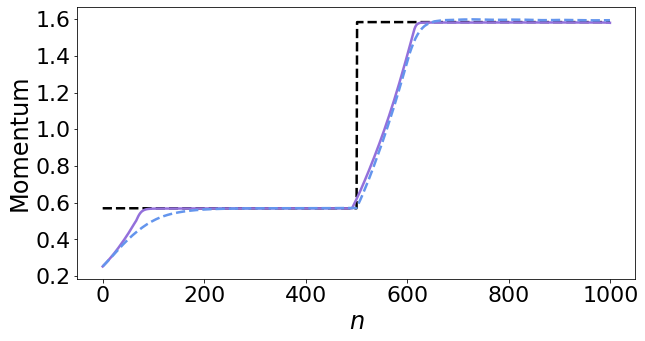

In [33]:

plt.figure(figsize=(10, 5))
plt.plot(momentum_ref, label="Reference", linestyle="--", color=ref_color, linewidth=linewidth)

plt.plot(
    pk_kdv_opt_momentum_5,
    label=r"$Ours(\lambda = 0.005)$",
    color=pk_curve, 
    linestyle=pk_linestyle, 
    linewidth=linewidth
)

plt.plot(
    vanilla_kdv_opt_momentum_5,
    label=r"$Vanilla(\lambda = 0.005)$",
    color=vanilla_curve, 
    linestyle=vanilla_linestyle, 
    linewidth=linewidth
)


plt.xticks(fontsize=ticks_font)
plt.yticks(fontsize=ticks_font)
plt.xlabel(r"$n$", fontsize=label_font)
plt.ylabel("Momentum", fontsize=label_font)


# plt.legend(fontsize=legend_font, loc=(1.05, 0.001))


# plt.savefig(os.path.join(figures_path, str(Nx)+'kdv_'+forcing_type+'_momentum_tracking_tau'+str(tau)+'.png'), dpi=200, bbox_inches='tight')
# plt.savefig(os.path.join(figures_path, str(Nx)+'kdv_'+forcing_type+'_momentum_tracking_tau'+str(tau)+'.pdf'), dpi=200, bbox_inches='tight')

# plt.close()


# Save data

In [34]:
# import pandas as pd
# results_dict = {
#             'pk_kdv_opt_momentum_5': pk_kdv_opt_momentum_5,
#             'vanilla_kdv_opt_momentum_5': vanilla_kdv_opt_momentum_5,
#             'momentum_ref':momentum_ref,
#             'pk_t_list_momentum_5': pk_t_list_momentum_5,
#             'vanilla_t_list_momentum_5': vanilla_t_list_momentum_5
# }


# np.save(os.path.join(weights_path,'check_vanilla_'+str(Nx)+'.npy'), results_dict)
# results_dict_list_vanilla_momentum_5 = [dict(result) for result in vanilla_results_momentum_5]
# results_dict_list_vanilla_momentum_5_df = pd.DataFrame(results_dict_list_vanilla_momentum_5)
# results_dict_list_vanilla_momentum_5_df.to_csv(os.path.join(weights_path,'opt_results_vanilla_'+str(Nx)+'.csv'), index=False)



# results_dict_list_pk_momentum_5 = [dict(result) for result in pk_results_momentum_5]
# results_dict_list_pk_momentum_5_df = pd.DataFrame(results_dict_list_pk_momentum_5)
# results_dict_list_pk_momentum_5_df.to_csv(os.path.join(weights_path,'opt_results_pk_'+str(Nx)+'.csv'), index=False)



In [32]:
# import pandas as pd
# import os
# file_path = os.path.join(weights_path, 'check_vanilla_' + str(Nx) + '.npy')
# results_dict = np.load(file_path, allow_pickle=True).item()

# pk_kdv_opt_momentum_5 = results_dict['pk_kdv_opt_momentum_5']
# # vanilla_kdv_opt_momentum_5 = results_dict['vanilla_kdv_opt_momentum_5']
# momentum_ref = results_dict['momentum_ref']
# pk_t_list_momentum_5 = results_dict['pk_t_list_momentum_5']
# # vanilla_t_list_momentum_5 = results_dict['vanilla_t_list_momentum_5']
# import pandas as pd
# results_dict = {
#             'pk_kdv_opt_momentum_5': pk_kdv_opt_momentum_5,
#             'vanilla_kdv_opt_momentum_5': vanilla_kdv_opt_momentum_5,
#             'momentum_ref':momentum_ref,
#             'pk_t_list_momentum_5': pk_t_list_momentum_5,
#             'vanilla_t_list_momentum_5': vanilla_t_list_momentum_5
# }


# np.save(os.path.join(weights_path,'check_vanilla_'+str(Nx)+'.npy'), results_dict)
# results_dict_list_vanilla_momentum_5 = [dict(result) for result in vanilla_results_momentum_5]
# results_dict_list_vanilla_momentum_5_df = pd.DataFrame(results_dict_list_vanilla_momentum_5)
# results_dict_list_vanilla_momentum_5_df.to_csv(os.path.join(weights_path,'opt_results_vanilla_'+str(Nx)+'.csv'), index=False)

